# Legendre Memory Units in NengoDL

[![Open In
Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/nengo/nengo-dl/blob/master/docs/examples/lmu.ipynb)

Legendre Memory Units (LMUs) are a novel memory cell for recurrent neural networks,
described in [Voelker, Kajić, and Eliasmith (NeurIPS
2019)](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf).
We will not go into the underlying details of these methods here; for our purposes we
can think of this as an alternative to something like LSTMs. LMUs have achieved state of
the art performance on complex RNN tasks, which we will demonstrate here. See [the
paper](https://papers.nips.cc/paper/9689-legendre-memory-units-continuous-time-representation-in-recurrent-neural-networks.pdf)
for all the details!

In this example we will show how an LMU can be built in NengoDL, and used to solve the
Permuted Sequential MNIST (psMNIST) task.

First we need to set up the data for this task. We begin with the standard MNIST dataset
of handwritten digits:

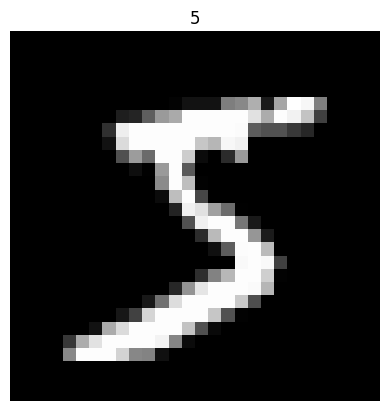

In [1]:
%matplotlib inline

from urllib.request import urlretrieve

import matplotlib.pyplot as plt
import nengo
from nengo.utils.filter_design import cont2discrete
import numpy as np
import tensorflow as tf

import nengo_dl

# set seed to ensure this example is reproducible
seed = 0
tf.random.set_seed(seed)
np.random.seed(seed)
rng = np.random.RandomState(seed)

# load mnist dataset
(train_images, train_labels), (
    test_images,
    test_labels,
) = tf.keras.datasets.mnist.load_data()

# change inputs to 0--1 range
train_images = train_images / 255
test_images = test_images / 255

# reshape the labels to rank 3 (as expected in Nengo)
train_labels = train_labels[:, None, None]
test_labels = test_labels[:, None, None]

plt.figure()
plt.imshow(np.reshape(train_images[0], (28, 28)), cmap="gray")
plt.axis("off")
plt.title(str(train_labels[0, 0, 0]))
plt.show()

"Sequential" MNIST refers to taking the pixels of the images and flattening them into a
sequence of single pixels. Each pixel will be presented to the network one at a time,
and the goal of the network is to classify the sequence according to which digit it
represents.

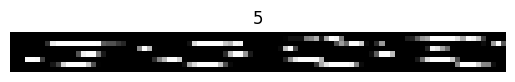

In [2]:
# flatten images into sequences
train_images = train_images.reshape((train_images.shape[0], -1, 1))
test_images = test_images.reshape((test_images.shape[0], -1, 1))

# we'll display the sequence in 8 rows just so that it fits better on the screen
plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(str(train_labels[0, 0, 0]))
plt.show()

As we can see, after flattening the image there is still a decent amount of structure
remaining. "Permuted" sequential MNIST makes the task more difficult by applying a fixed
permutation to all of the image sequences. This ensures that the information contained
in the image is distributed evenly throughout the sequence, so the RNN really does need
to process the whole length of the input sequence.

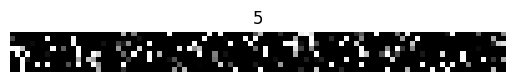

In [3]:
# apply permutation
perm = rng.permutation(train_images.shape[1])
train_images = train_images[:, perm]
test_images = test_images[:, perm]

plt.figure()
plt.imshow(train_images[0].reshape(8, -1), cmap="gray")
plt.axis("off")
plt.title(str(train_labels[0, 0, 0]))
plt.show()

Next we define the LMU cell.  This is a modified version of the implementation from
[KerasLMU](https://www.nengo.ai/keras-lmu/); see the documentation there for more
details. A single LMU cell is
implementing this computational graph:

![Computational graph](https://i.imgur.com/IJGUVg6.png)

In [4]:
class LMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))

        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in=(units,), pass_time=False)

            # compute u_t from the above diagram. we have removed e_h and e_m as they
            # are not needed in this task.
            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d)), synapse=None
            )

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}.
            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x, self.h, transform=nengo_dl.dists.Glorot(), synapse=None
            )
            nengo.Connection(
                self.h, self.h, transform=nengo_dl.dists.Glorot(), synapse=0
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(),
                synapse=None,
            )

And then we construct a simple network consisting of an input node, a single LMU cell,
and a dense linear readout. It is also possible to chain multiple LMU cells together,
but that is not necessary in this task.

In [5]:
with nengo.Network(seed=seed) as net:
    # remove some unnecessary features to speed up the training
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )

    # input node
    inp = nengo.Node(np.zeros(train_images.shape[-1]))

    # lmu cell
    lmu = LMUCell(
        units=212,
        order=256,
        theta=train_images.shape[1],
        input_d=train_images.shape[-1],
    )
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False

    # dense linear readout
    out = nengo.Node(size_in=10)
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    # record output. note that we set keep_history=False above, so this will
    # only record the output on the last timestep (which is all we need
    # on this task)
    p = nengo.Probe(out)

And now we can train the model. To save time in this example we will download some
pretrained weights, but you can set `do_training=True` below to run the training
yourself.  Note that even with `do_training=True` we're only training for 10 epochs,
which is dramatically less than many other solutions to this task.  We could train for
longer if we wanted to really fine-tune performance.

In [6]:
do_training = False

with nengo_dl.Simulator(net, minibatch_size=100, unroll_simulation=16) as sim:
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=["accuracy"],
    )

    test_acc = sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    print(f"Initial test accuracy: {test_acc * 100:.2f}%")

    if do_training:
        sim.fit(train_images, train_labels, epochs=10)
        sim.save_params("./lmu_params")
    else:
        urlretrieve(
            "https://drive.google.com/uc?export=download&"
            "id=1UbVJ4u6eQkyxIU9F7yScElAz2p2Ah2sP",
            "lmu_params.npz",
        )
        sim.load_params("./lmu_params")

    test_acc = sim.evaluate(test_images, test_labels, verbose=0)["probe_accuracy"]
    print(f"Final test accuracy: {test_acc * 100:.2f}")

|                     Building network (0%)                    | ETA:  --:--:--

Build finished in 0:00:00                                                      

|#                         Optimizing graph                           | 0:00:00

|#             Optimizing graph: operator simplificaton               | 0:00:00

Optimizing graph: operator simplificaton finished in 0:00:00                   

|#                Optimizing graph: merging operators                 | 0:00:00

Optimizing graph: merging operators finished in 0:00:00                        

|#                Optimizing graph: ordering signals                  | 0:00:00

Optimizing graph: ordering signals finished in 0:00:00                         

|#                Optimizing graph: creating signals                  | 0:00:00

Optimizing graph: creating signals finished in 0:00:00                         

Optimization finished in 0:00:00                                               

|#                        Constructing graph                          | 0:00:00

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|              Constructing graph: build stage (1%)              | ETA: 0:00:06

|#             Constructing graph: build stage (2%)              | ETA: 0:00:05

|###           Constructing graph: build stage (4%)              | ETA: 0:00:03

|####          Constructing graph: build stage (7%)              | ETA: 0:00:03

|########      Constructing graph: build stage (12%)             | ETA: 0:00:02

|#########     Constructing graph: build stage (15%)             | ETA: 0:00:01

|############  Constructing graph: build stage (19%)             | ETA: 0:00:01

|##############Constructing graph: build stage (25%)             | ETA: 0:00:01

|##############Constructing graph: build stage (27%)             | ETA: 0:00:01

|##############Constructing graph: build stage (31%)             | ETA: 0:00:01

|##############Constructing graph: build stage (36%)             | ETA: 0:00:01

|##############Constructing graph: build stage (40%)             | ETA: 0:00:00

|##############Constructing graph: build stage (44%)             | ETA: 0:00:00

|##############Constructing graph: build stage (48%)             | ETA: 0:00:00

|##############Constructing graph: build stage (52%)             | ETA: 0:00:00

|##############Constructing graph: build stage (56%)             | ETA: 0:00:00

|##############Constructing graph: build stage (61%)             | ETA: 0:00:00

|##############Constructing graph: build stage (65%)             | ETA: 0:00:00

|##############Constructing graph: build stage (68%)             | ETA: 0:00:00

|##############Constructing graph: build stage (73%)             | ETA: 0:00:00

|##############Constructing graph: build stage (76%)             | ETA: 0:00:00

|##############Constructing graph: build stage (81%)#            | ETA: 0:00:00

|##############Constructing graph: build stage (85%)###          | ETA: 0:00:00

|##############Constructing graph: build stage (89%)######       | ETA: 0:00:00

|##############Constructing graph: build stage (93%)#########    | ETA: 0:00:00

|##############Constructing graph: build stage (98%)###########  | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:01                            

Construction finished in 0:00:01                                               

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|              Constructing graph: build stage (1%)              | ETA: 0:00:06

|#             Constructing graph: build stage (2%)              | ETA: 0:00:04

|###           Constructing graph: build stage (4%)              | ETA: 0:00:03

|#####         Constructing graph: build stage (8%)              | ETA: 0:00:02

|########      Constructing graph: build stage (12%)             | ETA: 0:00:02

|##########    Constructing graph: build stage (15%)             | ETA: 0:00:01

|############  Constructing graph: build stage (19%)             | ETA: 0:00:01

|##############Constructing graph: build stage (25%)             | ETA: 0:00:01

|##############Constructing graph: build stage (27%)             | ETA: 0:00:01

|##############Constructing graph: build stage (31%)             | ETA: 0:00:01

|##############Constructing graph: build stage (36%)             | ETA: 0:00:01

|##############Constructing graph: build stage (39%)             | ETA: 0:00:01

|##############Constructing graph: build stage (43%)             | ETA: 0:00:00

|##############Constructing graph: build stage (47%)             | ETA: 0:00:00

|##############Constructing graph: build stage (51%)             | ETA: 0:00:00

|##############Constructing graph: build stage (56%)             | ETA: 0:00:00

|##############Constructing graph: build stage (58%)             | ETA: 0:00:00

|##############Constructing graph: build stage (62%)             | ETA: 0:00:00

|##############Constructing graph: build stage (65%)             | ETA: 0:00:00

|##############Constructing graph: build stage (68%)             | ETA: 0:00:00

|##############Constructing graph: build stage (73%)             | ETA: 0:00:00

|##############Constructing graph: build stage (76%)             | ETA: 0:00:00

|##############Constructing graph: build stage (81%)#            | ETA: 0:00:00

|##############Constructing graph: build stage (84%)##           | ETA: 0:00:00

|##############Constructing graph: build stage (88%)#####        | ETA: 0:00:00

|##############Constructing graph: build stage (92%)########     | ETA: 0:00:00

|##############Constructing graph: build stage (95%)##########   | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:01                            

|           Constructing graph: pre-build stage (0%)           | ETA:  --:--:--

Constructing graph: pre-build stage finished in 0:00:00                        

|             Constructing graph: build stage (0%)             | ETA:  --:--:--

|              Constructing graph: build stage (1%)              | ETA: 0:00:06

|#             Constructing graph: build stage (2%)              | ETA: 0:00:04

|###           Constructing graph: build stage (5%)              | ETA: 0:00:03

|#####         Constructing graph: build stage (8%)              | ETA: 0:00:02

|########      Constructing graph: build stage (12%)             | ETA: 0:00:02

|#########     Constructing graph: build stage (15%)             | ETA: 0:00:01

|############  Constructing graph: build stage (19%)             | ETA: 0:00:01

|##############Constructing graph: build stage (23%)             | ETA: 0:00:01

|##############Constructing graph: build stage (26%)             | ETA: 0:00:01

|##############Constructing graph: build stage (31%)             | ETA: 0:00:01

|##############Constructing graph: build stage (34%)             | ETA: 0:00:01

|##############Constructing graph: build stage (38%)             | ETA: 0:00:01

|##############Constructing graph: build stage (43%)             | ETA: 0:00:00

|##############Constructing graph: build stage (46%)             | ETA: 0:00:00

|##############Constructing graph: build stage (50%)             | ETA: 0:00:00

|##############Constructing graph: build stage (54%)             | ETA: 0:00:00

|##############Constructing graph: build stage (57%)             | ETA: 0:00:00

|##############Constructing graph: build stage (62%)             | ETA: 0:00:00

|##############Constructing graph: build stage (65%)             | ETA: 0:00:00

|##############Constructing graph: build stage (68%)             | ETA: 0:00:00

|##############Constructing graph: build stage (73%)             | ETA: 0:00:00

|##############Constructing graph: build stage (76%)             | ETA: 0:00:00

|##############Constructing graph: build stage (81%)#            | ETA: 0:00:00

|##############Constructing graph: build stage (84%)###          | ETA: 0:00:00

|##############Constructing graph: build stage (88%)#####        | ETA: 0:00:00

|##############Constructing graph: build stage (93%)#########    | ETA: 0:00:00

|##############Constructing graph: build stage (96%)##########   | ETA: 0:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

|############Constructing graph: build stage (100%)############| ETA:  00:00:00

Constructing graph: build stage finished in 0:00:01                            

Initial test accuracy: 7.98%


Final test accuracy: 96.15


We can see that the network is achieving >96% accuracy, which is state of the art
performance on psMNIST.